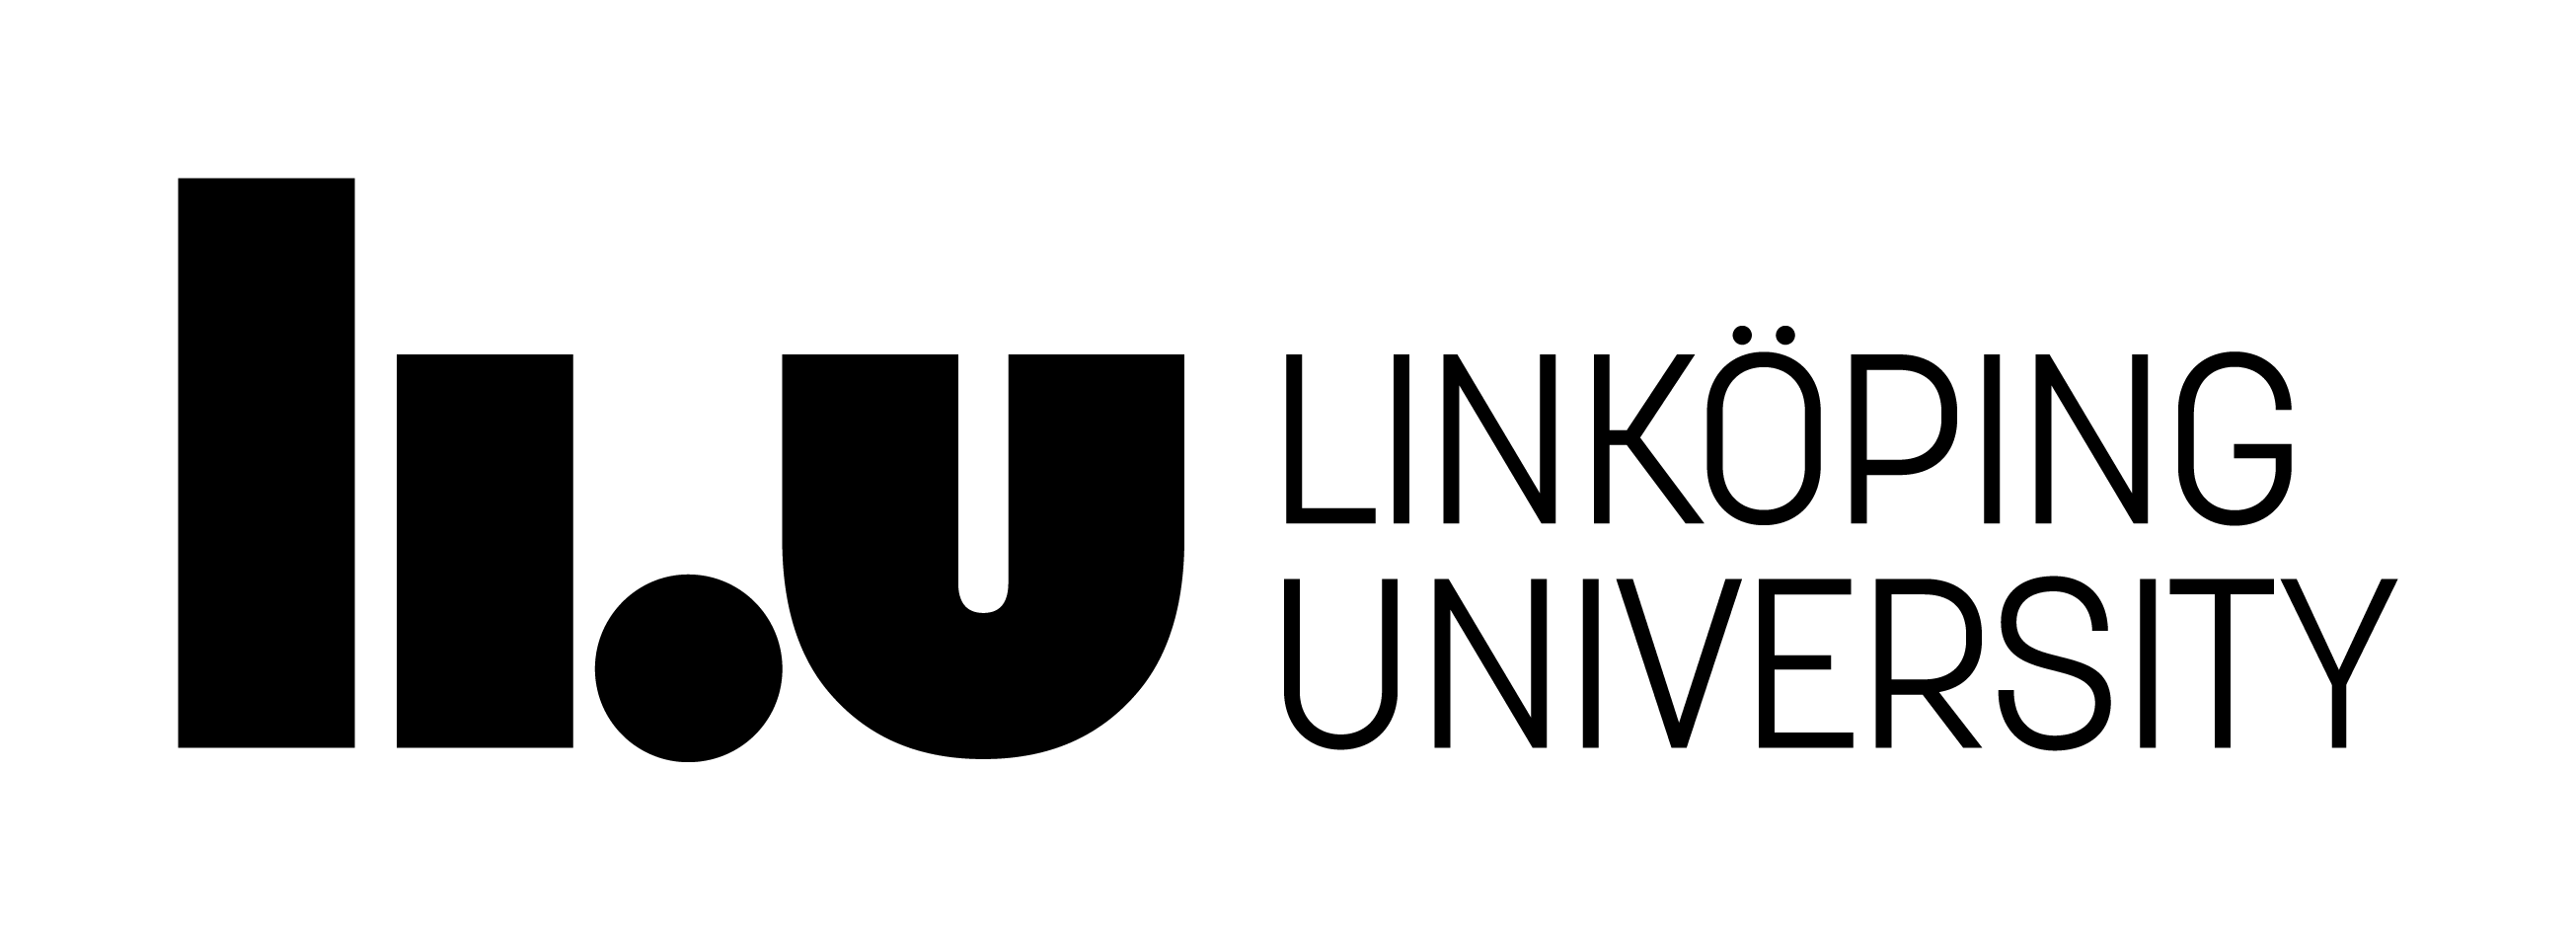
## Linkoping University: TDDC17 Artificial Intelligence
---



**Lab6 : Reinforcement Learning**


This lab focuses on understanding the fundamentals of RL, including MDP, and implementing key RL algorithms model-free (on-policy and off-policy). The lab uses [Gym/Gymnasium](https://gymnasium.farama.org/), a standard toolkit for developing and comparing
RL algorithms in simulated environments.

##Install these dependancies

##Import libraries

In [7]:
import matplotlib
%matplotlib inline
import gym
import itertools
import numpy as np
import sys
from io import StringIO
from gym import Env, spaces
from gym import spaces
from gym.utils import seeding
from collections import defaultdict
import pandas as pd
from collections import namedtuple
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

EpisodeStats = namedtuple("Stats",["episode_lengths", "episode_rewards"])

In [8]:
## functions used for plotting
def plot_value_function(V, title="Value Function"):
    """
    Plots the value function as a surface plot.
    """
    min_x = min(k[0] for k in V.keys())
    max_x = max(k[0] for k in V.keys())
    min_y = min(k[1] for k in V.keys())
    max_y = max(k[1] for k in V.keys())

    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)

    # Find value for all (x, y) coordinates
    Z_noace = np.apply_along_axis(lambda _: V[(_[0], _[1], False)], 2, np.dstack([X, Y]))
    Z_ace = np.apply_along_axis(lambda _: V[(_[0], _[1], True)], 2, np.dstack([X, Y]))

    def plot_surface(X, Y, Z, title):
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                               cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player Sum')
        ax.set_ylabel('Dealer Showing')
        ax.set_zlabel('Value')
        ax.set_title(title)
        ax.view_init(ax.elev, -120)
        fig.colorbar(surf)
        plt.show()

    plot_surface(X, Y, Z_noace, "{} (No Usable Ace)".format(title))
    plot_surface(X, Y, Z_ace, "{} (Usable Ace)".format(title))



def plot_episode_stats(stats, smoothing_window=10, noshow=False):
    # Plot the episode length over time
    fig1 = plt.figure(figsize=(10,5))
    plt.plot(stats.episode_lengths)
    plt.xlabel("Episode")
    plt.ylabel("Episode Length")
    plt.title("Episode Length over Time")
    if noshow:
        plt.close(fig1)
    else:
        plt.show(fig1)

    # Plot the episode reward over time
    fig2 = plt.figure(figsize=(10,5))
    rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    if noshow:
        plt.close(fig2)
    else:
        plt.show(fig2)

    # Plot time steps and episode number
    fig3 = plt.figure(figsize=(10,5))
    plt.plot(np.cumsum(stats.episode_lengths), np.arange(len(stats.episode_lengths)))
    plt.xlabel("Time Steps")
    plt.ylabel("Episode")
    plt.title("Episode per time step")
    if noshow:
        plt.close(fig3)
    else:
        plt.show(fig3)

    return fig1, fig2, fig3

# Part I: Monte Carlo and Temporal Difference Learning

---

### Why can't we always rely on Policy / Value Iteration ?

At each state, we look ahead one step at each possible action and next state.

1.  We can only do this because we have a perfect model of the environment. (the transition matrix $P$). In most applications, this assumption does not hold. We would like an algorithm that can learn from $\mathcal{experience}$, i.e. by simply interacting with the environment
2.  DP methods are polynomial in the number of states. Many real world applications have a very large state space, making DP methods unusable



## Prediction
Given a policy $\pi$,  can we find the corresponding value function $v_{\pi}$ ?

Sample episodes of experience and estimate V(s) to be the reward received from that state onwards averaged across all of your experience. The same technique works for the action-value function Q(s, a). Given enough samples, this is proven to converge.

### MC prediction Algorithm
**Input**: <br>
a policy $\pi$ to be evaluated <br>
the number of episodes for which the run the algorithm, *num_episodes*

**Initialize**:

$ \quad V(s) \in \mathbb{R}$, arbitrarily, for all $s \in S $ <br>
$ \quad \textit{VisitCount(s)}$, an empty list, for all $s \in S$

**Loop** (for *num_episodes*): <br>
$ \quad $ Generate an episode following $\pi: S_0,A_0,R_1,S_1,A_1,R_2, ..., S_{T-1},A_{T-1},R_T$ <br>
$ \quad G \leftarrow 0$ <br>
$ \quad $ **Loop** for each step of episode, $t = T-1, T-2, ..., 0$: <br>
$ \quad \quad G \leftarrow \gamma G + R_{t+1} $ <br>
$ \quad \quad \textit{VisitCount}(S_t) = \textit{VisitCount}(S_t) + 1$ <br>
$ \quad \quad V(S_t) = V(S_t) + \frac{1}{\textit{VisitCount}(S_t)} (G_t - V(S_t))$

return $V$

### Implementation
We consider the game of blackjack for this exercice, available [here](https://www.gymlibrary.dev/environments/toy_text/blackjack/). I recommend exploring the previous link, to get familiar with the API of the environment.


#### The BlackJack Environment
This environment actually builds off the gym interface, so you can interact with it using the same function calls. Here's a quick example

In [9]:
# create env
env = gym.make('Blackjack-v1', natural=False, sab=False)

# reset env
state = env.reset()

# let's see what's hidden inside this Object
print(vars(env))

# how big is the action space ?
print (env.action_space.n)


# let's sample a random action
random_action = env.action_space.sample()



# let's simulate one action
observation, reward, done, _ = env.step(random_action)
print(observation)
print(reward)
(done)

# observation : the new state after executing action
# reward      : observed reward after executing action
# done        : `True` if the episode is over, `False` otherwise

# let's reset the environment (do this when `done` == True)
state = env.reset()

{'env': <gym.envs.toy_text.blackjack.BlackjackEnv object at 0xffff6cd4e9d0>, '_action_space': None, '_observation_space': None, '_reward_range': None, '_metadata': None, '_has_reset': True}
2
(22, 1, False)
-1.0


In [24]:
def mc_prediction(policy, env, num_episodes, discount_factor=1.0, max_steps_per_episode=100):
    """
    Monte Carlo prediction algorithm. Calculates the value function
    for a given policy using sampling.

    Args:
        policy: A function that maps an observation to action probabilities.
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.

    Returns:
        A dictionary that maps from state -> value.
        The state is a tuple and the value is a float.
    """

    # Keeps track of sum and count of returns for each state
    returns_sum   = defaultdict(float)
    returns_count = defaultdict(float)

    # The final value function
    V = defaultdict(float)

    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode+1) % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        # Generate an episode.
        # An episode is an array of (state, action, reward) tuples
        episode = []
        state = env.reset()
        done = False

        while not done:
            #<add code> use the policy
            action = policy(state) 
            #<add code> take a step
            next_state, reward, done, _ = env.step(action) 
            #<add code> append (state, action, reward) to episode array, it will be used later to update the state value V
            episode.append((state, action, reward))
            #<add code> move to next state
            state = next_state 

        discounted_return = 0
        for (state, action, reward) in episode[::-1]:
            #<add code> calculate the discounted return
            discounted_return = discount_factor * discounted_return + reward 
            returns_count[state] += 1
            #<add code> use the question in the pseudo-code to update V[state]
            V[state] += 1 / returns_count[state] * (discounted_return - V[state]) 

    return V

Since we want to do policy evaluation, we'll need a policy. Let's create one

In [25]:
def sample_policy(observation):
    """
    A policy that sticks if the player score is >= 20 and hits otherwise.
    """
    score, dealer_score, usable_ace = observation
    return 0 if score >= 20 else 1

Episode 9999/10000.

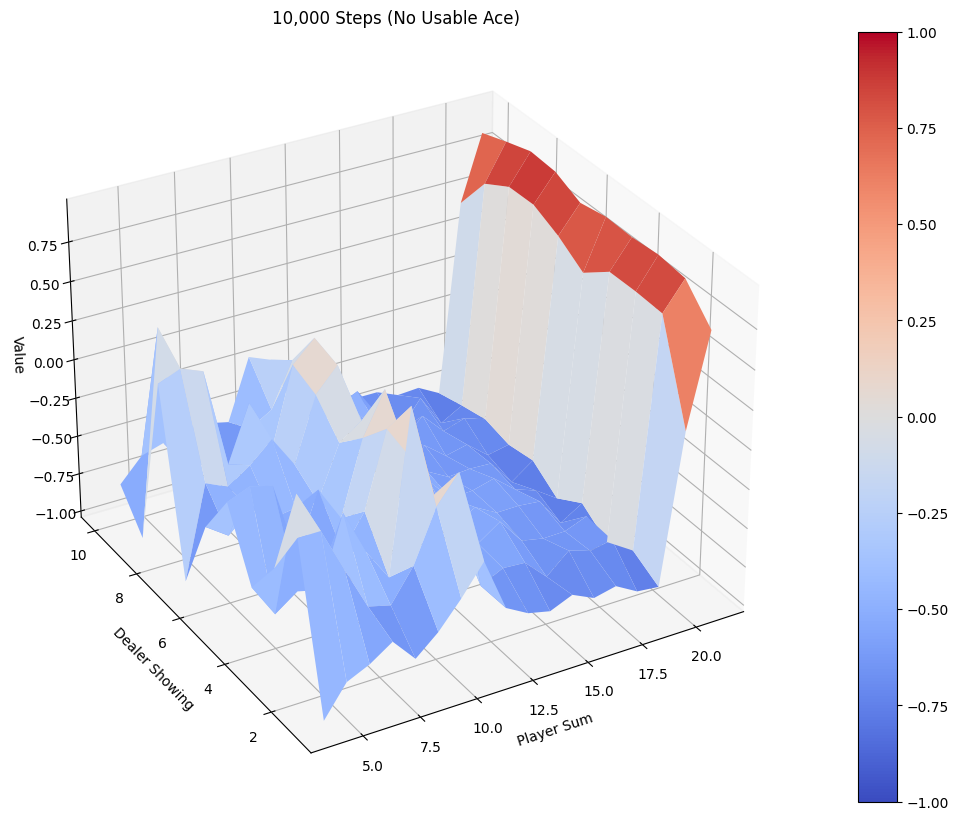

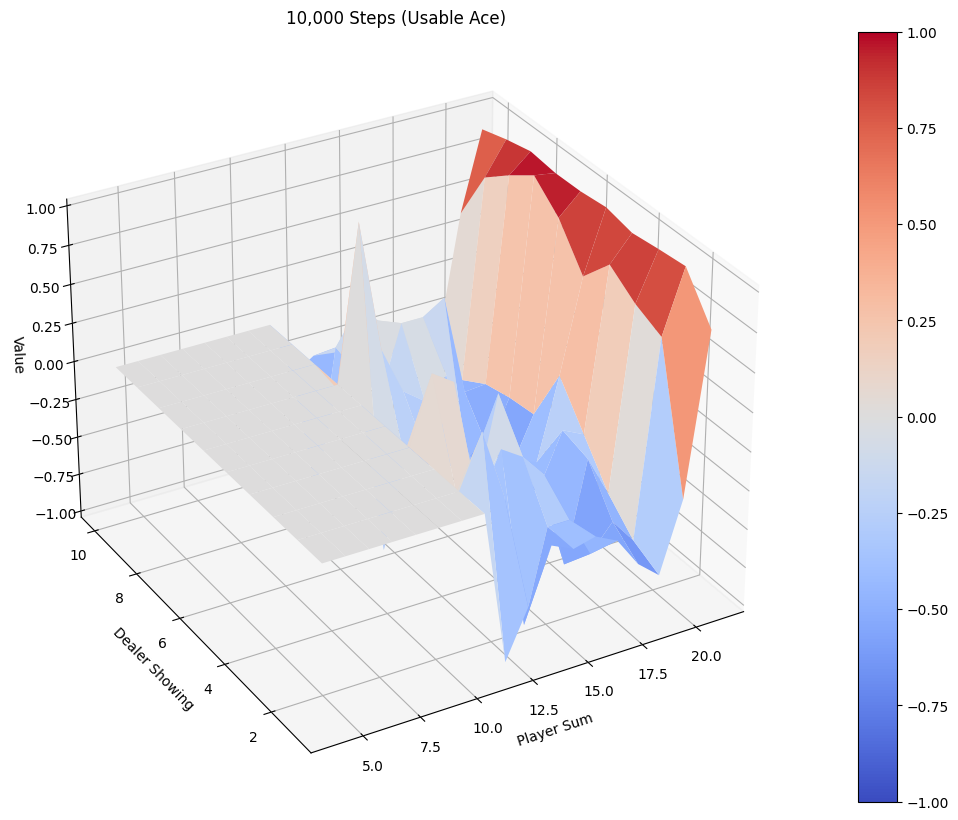

In [26]:
env = gym.make('Blackjack-v1')
V_10k = mc_prediction(sample_policy, env, num_episodes=10000)
plot_value_function(V_10k, title="10,000 Steps")

Once your algorithm seems to run correctly, run it longer to see what the real value prediction looks like!

Episode 499999/500000.

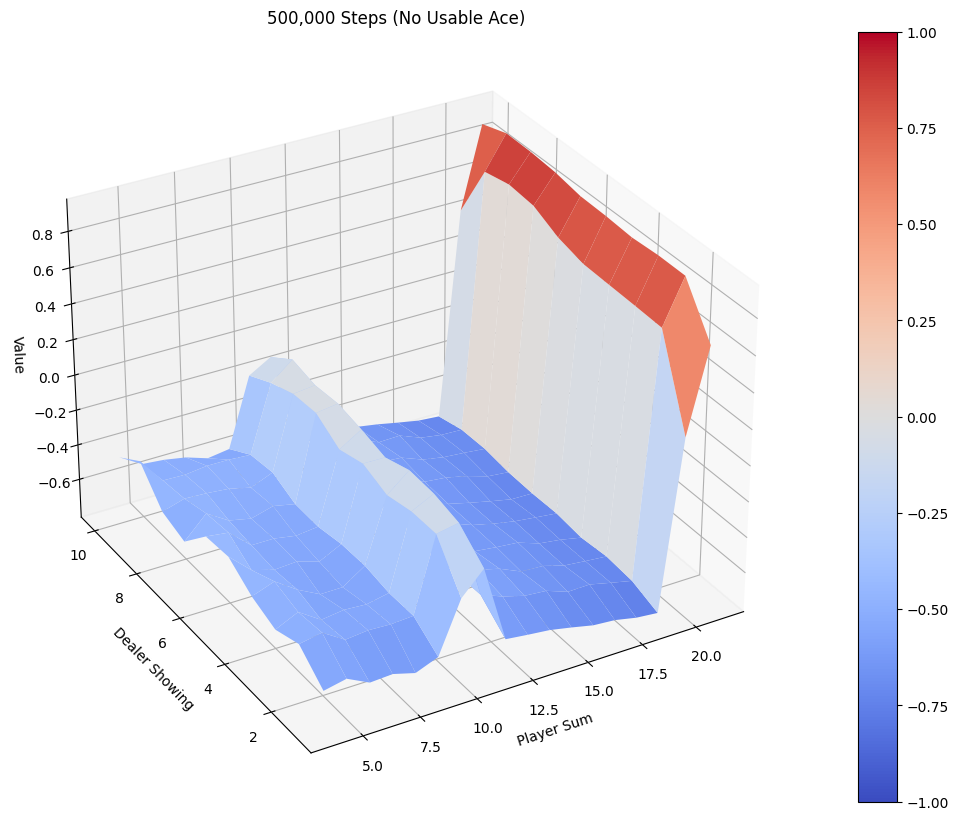

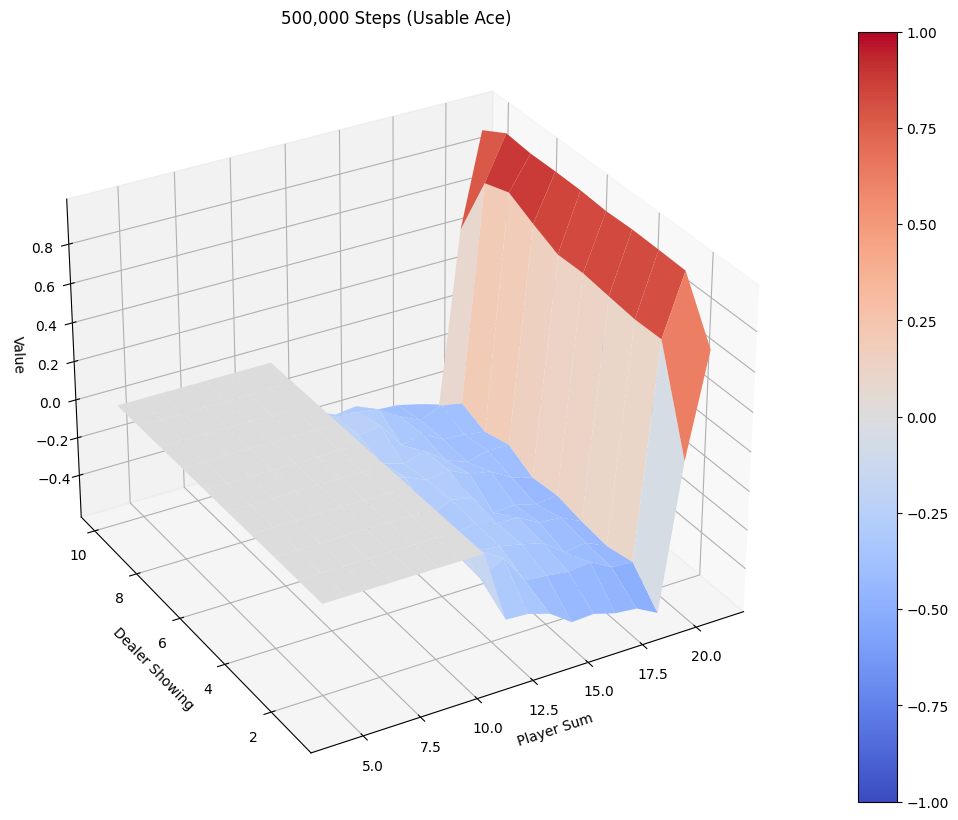

In [27]:
V_500k = mc_prediction(sample_policy, env, num_episodes=500000)
plot_value_function(V_500k, title="500,000 Steps")

As expected, the more episode you run, the better your estimate gets. This is shown by the plots being much smoother for $t=500000$ vs $t=10000$

## Control
The idea is the same as for Dynamic Programming. Use MC Policy Evaluation to evaluate the current policy then improve the policy greedily. The Problem: How do we ensure that we explore all states if we don't know the full environment?

Solution to exploration problem: Use epsilon-greedy policies instead of full greedy policies. When making a decision act randomly with probability epsilon. This will learn the optimal epsilon-greedy policy.

### MC Control Algorithm
**Input**: <br>
small $\epsilon > 0$  <br>
the number of episodes for which the run the algorithm, *num_episodes*

** Initialize: ** <br>
$ \quad \pi \leftarrow $ an arbitrary $\epsilon$-soft policy <br>
$ \quad Q(s,a) \in \mathbb{R}$ (arbitrarily), for all $s \in S, a \in A(s)$ <br>
$ \quad \textit{VisitCount(s,a)}$, an empty list, for all $s \in S, a \in A(s)$

**Loop** (for *num_episodes*): <br>
$ \quad $ Generate an episode following $\pi: S_0,A_0,R_1,S_1,A_1,R_2, ..., S_{T-1},A_{T-1},R_T$ <br>
$ \quad G \leftarrow 0$ <br>
$ \quad $ **Loop** for each step of episode, $t = T-1, T-2, ..., 0$: <br>
$ \quad \quad \textit{VisitCount}(S_t, A_t) = \textit{VisitCount}(S_t, A_t) + 1$ <br>
$ \quad \quad G \leftarrow \gamma G + R_{t+1} $ <br>
$ \quad \quad Q(S_t, A_t) = Q(S_t, A_t) + \frac{1}{\textit{VisitCount}(S_t, A_t)} (G_t - Q(S_t, A_t))$

$\quad $** Update ** $\pi$ to be $\epsilon$-greedy w.r.t. the update $Q$ values

return $Q, \ \pi$

### Implementation
It's important to break ties arbitrarily when doing control. This is especially important when you initialize all $Q$ or $V$ array to all 0s. If you don't break ties arbitrarily, you will end up always choosing the same action!. Here is a ** argmax ** function that break ties randomly

In [28]:
def argmax(numpy_array):
    """ argmax implementation that chooses randomly between ties """
    max_indices = np.where(numpy_array == numpy_array.max())[0]
    return max_indices[np.random.randint(max_indices.shape[0])]

We are also providing you with the following function: Given a $Q$ dictionnary and $\epsilon$, it returns a $\epsilon$-greedy policy. Also, since the argument $Q$ is a python object, the returned $\epsilon$-greedy policy will automatically update as you change the $Q$ values.

In [29]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.

    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.

    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.

    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [30]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1, max_steps_per_episode=100):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.

    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.

    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """

    # Keeps track of sum and count of returns for each state
    returns_sum   = defaultdict(float)
    returns_count = defaultdict(float)

    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # The policy we're following
    #<add code> call the correct policy
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)

    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode+1) % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        # Generate an episode.
        # An episode is an array of (state, action, reward) tuples
        episode = []
        state = env.reset()
        for t in range(max_steps_per_episode):
            #<add code> use the policy to get the action probability
            probs = policy(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            #<add code> make a step by executing the action
            next_state, reward, done, _ = env.step(action)
            episode += [(state, action, reward)]

            if done:
                break

            state = next_state

        discounted_return = 0
        for (state, action, reward) in episode[::-1]:
            #<add code> calculate the discounted return
            discounted_return = discount_factor * discounted_return + reward
            returns_count[(state, action)] += 1
            #<add code> refer to the pseudo-code to compute the state-action value update Q[state][action]
            Q[state][action] += 1 / returns_count[(state, action)] * (discounted_return - Q[state][action])

    return Q, policy

In [31]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

Episode 499999/500000.

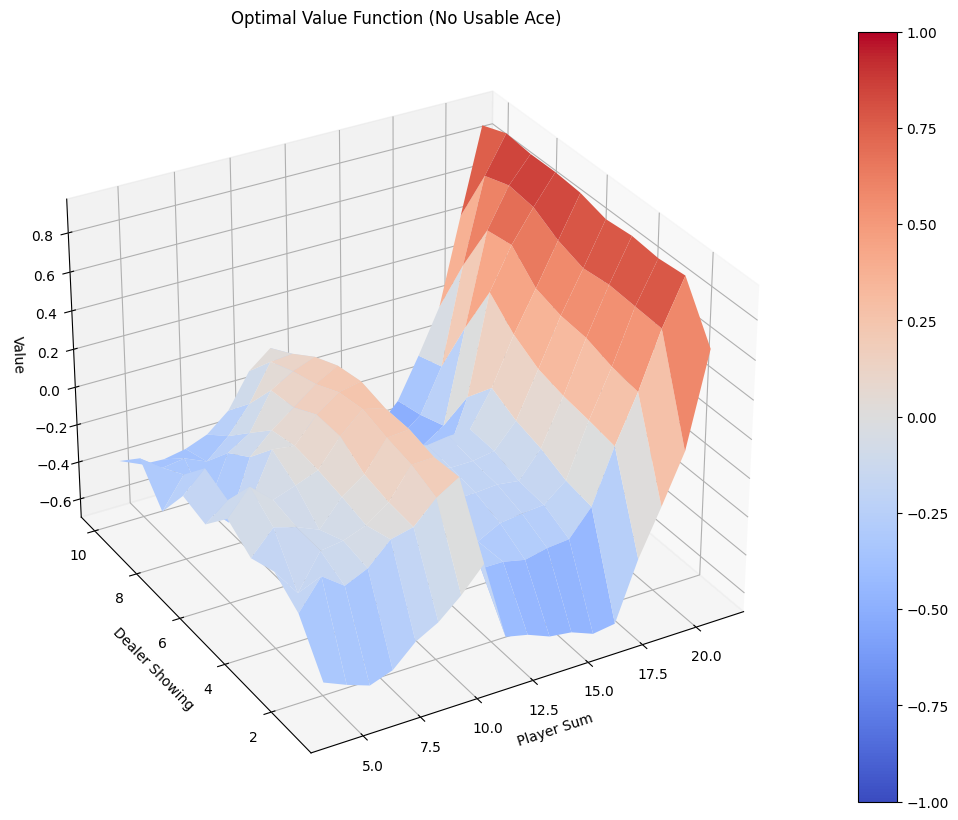

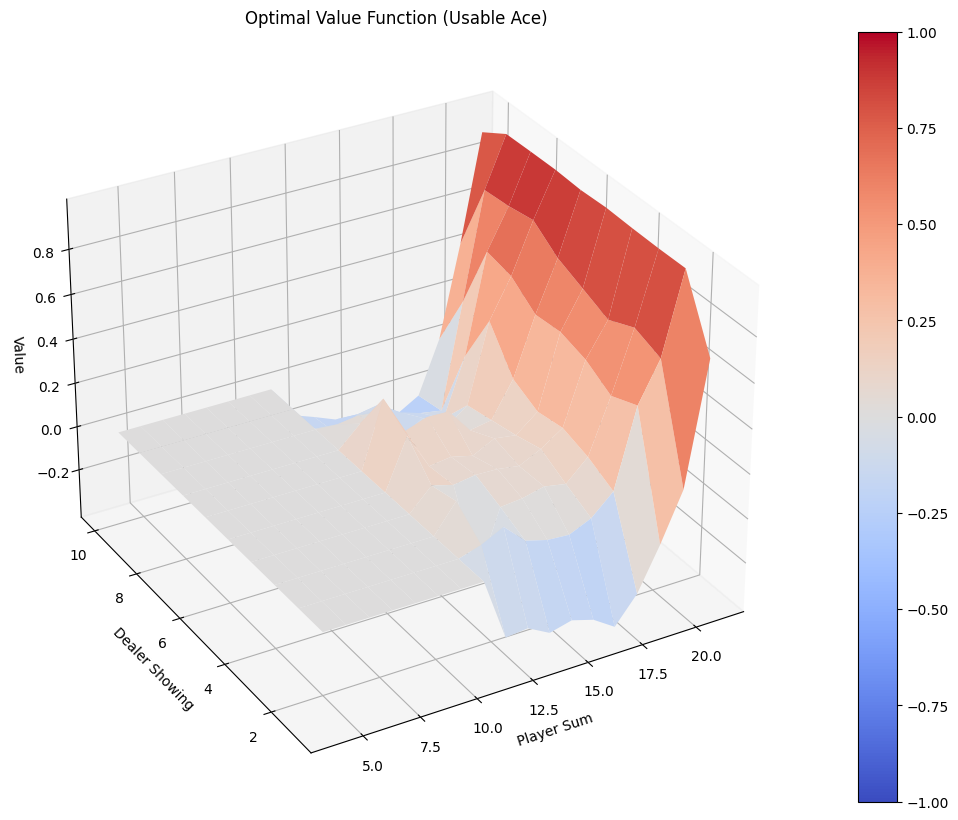

In [32]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plot_value_function(V, title="Optimal Value Function")

### Comments on MC methods
So far we have been using the following update rule for MC Control and Prediction

1) For a given state action pair $(s_t, a_t)$, observe the return $G_t$

2) Update your estimate in this fashion $V(s_t)$ = $V(s_t) + \frac{1}{VisitCount(s_t)} \bigg[G_t - V(s_t)\bigg] $

It's important to notice that this assings **equal importance to all returns**. In general, this can be problematic when working with nonstationary environments. In this setup, it would be better to *trust/rely more* on newer $Returns$, and rely less on older ones. One easy way to achieve this is by using the following update rule

$$V(s_t) \leftarrow V(s_t) + \alpha \bigg[ G_t - V(s_t) \bigg]$$

This update rule will assign exponentially decresing weights over time. Feel free to (re) implement the above exercises with this update rule. You will not need the returns_count array anymore

### Drawbacks of Monte Carlo methods


1.   You need to wait until the end of the episode to perform an update. This can be probablematic if the episode lengths are very long, (or even infinite!)
2.   MC methods, while unbiased, tend to have high variance. To see this, note that $$G_t = R_{t+1} + \gamma R_{t+2} + ... + \gamma^{T - t - 1}R_{T}$$ What will be the variance of $G_t$ ? Assuming all the returns are independent*, $$Var(G_t) = Var(R_{t+1}) + \gamma^2 Var(R_{t+2}) + ... + \gamma^{2(T - t - 1)}Var(R_{T})$$

which can become quite large for long episodes.

Ideally, we would like a way to trade off bias for variance. This leads us to the next topic of Temporal Difference Learning.

---


*Independence of returns is not true in general, but the intuition of the variance growing with the size of the episode is still valid


### TD  prediction Algorithm
**Input**: <br>
a policy $\pi$ to be evaluated <br>
step size $\alpha \in (0, 1]$ <br>
the number of episodes for which the run the algorithm, *num_episodes*

**Initialize**:

$ \quad V(s) \in \mathbb{R}$, arbitrarily, for all $s \in S $, except that $V(terminal)=0$ <br>

**Loop** (for *num_episodes*): <br>
$ \quad $ Initialize $S$ <br>
$ \quad $ **Loop** for each step of the episode: <br>
$ \quad \quad A \leftarrow $ action given by $\pi$ for S <br>
$ \quad \quad $ Take action $A$, observe $R, S'$ <br>
$ \quad \quad V(S) \leftarrow V(S) + \alpha \big[ R + \gamma V(S') - V(s) \big]$ <br>
return $V$

### TD Control and Q-Learning
Let's skip prediction for TD methods and go straight to control. Arguably the most famous TD algorithm is Q-Learning, with the following pseudocode.

### Q-learning Algorithm
**Input**: <br>
step size $\alpha \in (0, 1]$ <br>
the number of episodes for which the run the algorithm, *num_episodes*

**Initialize**:

$\quad Q(s, a) \in \mathbb{R}$ arbitrarily, for all $s \in S, a \in A(s)$, except that $Q(terminal, \cdot)=0$ <br>

**Loop** (for *num_episodes*): <br>
$ \quad $ Initialize $S$ <br>
$ \quad $ **Loop** for each step of the episode: <br>
$ \quad \quad $ Choose $A$ from $S$ using policy derived from $Q$, (e.g. $\epsilon$-greedy) <br>
$ \quad \quad $ Take action $A$, observe $R, S'$ <br>
$ \quad \quad Q(S, A) \leftarrow Q(S, A) + \alpha \big[ R + \gamma \max_a Q(S', a) - Q(s,a) \big]$ <br>
$ \quad $ until S is terminal

return $Q, \ \pi$

### Implementation
We consider the CliffWorld for this exercice, available [here](https://github.com/dennybritz/reinforcement-learning/blob/master/lib/envs/cliff_walking.py). The API is the same as the other environment, i.e. you can use the same function calls to interact with it.
![env](https://i.imgur.com/qz5Kdyf.png)

In [33]:
env = gym.make('CliffWalking-v0')

In [38]:
def q_learning(env, num_episodes, discount_factor=1.0, epsilon=0.05, alpha=0.5):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy

    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.

    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # The policy we're following
    #<add code> call the correct policy
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)

    # Keeps track of useful statistics
    stats = EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))

    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode +1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        # reset environment at the beginning of every episode
        state = env.reset()

        for t in itertools.count():

            # Take a step (q-l, not sarsa)
            #<add code> call the correct policy
            probs = policy(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            #<add code> make a step after executing an action
            next_state, reward, done, _ = env.step(action)

            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t

            # TD update
            #<add code> compute the best action
            if done:
                best_next_action = 0
            else:
                best_next_action = np.max(Q[next_state])

            # NOTE: would this line still if `next_state` is terminal AND Q is NOt initialized to all 0's ?
            #<add code> compute the td target based on the pseudo-code
            td_target = reward + discount_factor * best_next_action
            #<add code> compute the td error
            td_delta = td_target - Q[state][action]
            #<add code> then update the state-action value
            Q[state][action] += alpha * td_delta

            if done:
                break

            state = next_state


    return Q, stats

Episode 499/500.

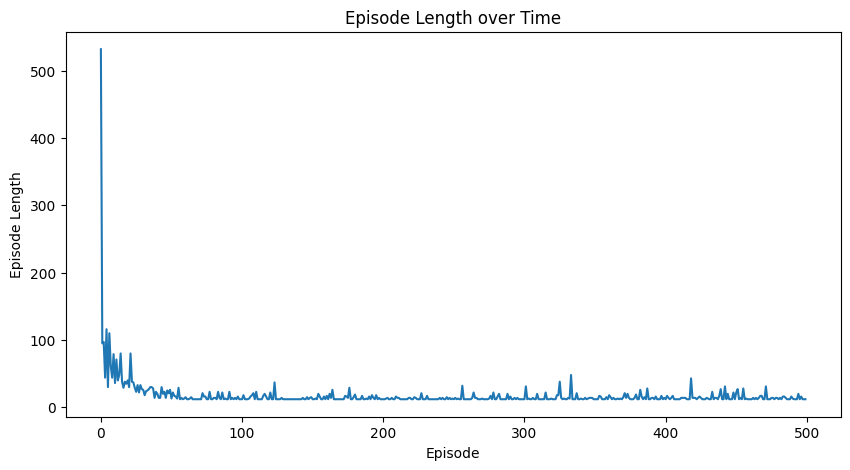

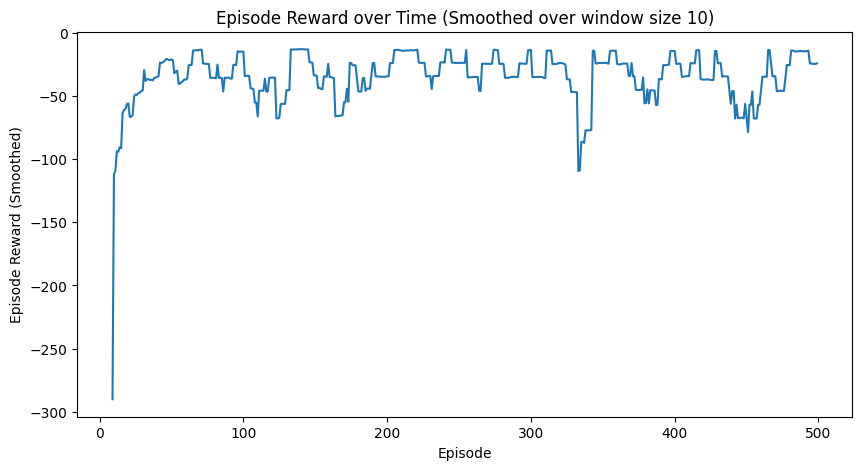

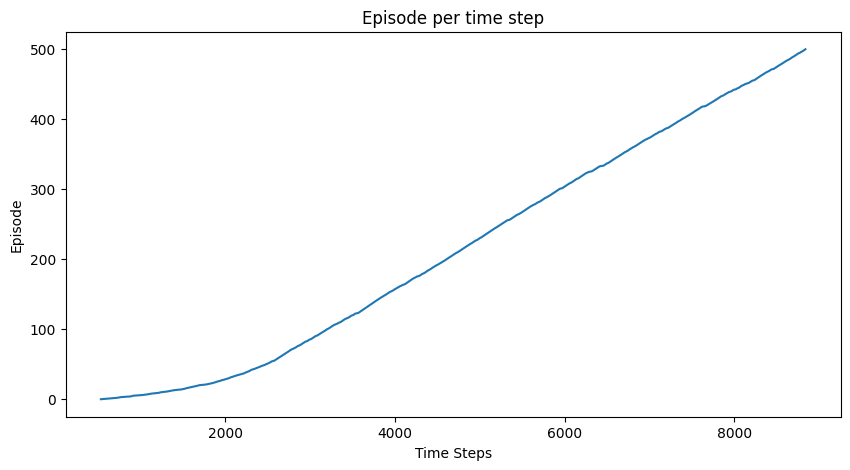

(<Figure size 1000x500 with 1 Axes>,
 <Figure size 1000x500 with 1 Axes>,
 <Figure size 1000x500 with 1 Axes>)

In [39]:
Q, stats_q_learning = q_learning(env, num_episodes=500)
plot_episode_stats(stats_q_learning)

### SARSA
Q-learning is an offline method, since the target update does not depend on the behavior policy (because of the max operator). The online version of Q-Learning is known as SARSA (which stands for State, Action, Reward, State, Action). Notice that in the following pseudocode, the action selected in the target update is the same as the action used in the next timestep

### SARSA Algorithm
**Input**: <br>
step size $\alpha \in (0, 1]$ <br>
the number of episodes for which the run the algorithm, *num_episodes*

**Initialize**:

$\quad Q(s, a) \in \mathbb{R}$ arbitrarily, for all $s \in S, a \in A(s)$, except that $Q(terminal, \cdot)=0$ <br>

**Loop** (for *num_episodes*): <br>
$ \quad $ Initialize $S$ <br>
$ \quad $ Choose $A$ from $S$ using policy derived from $Q$, (e.g. $\epsilon$-greedy) <br>
$ \quad $ **Loop** for each step of the episode: <br>
$ \quad \quad $ Take action $A$, observe $R, S'$ <br>
$ \quad \quad $ Choose $A'$ from $S'$ using policy derived from $Q$, (e.g. $\epsilon$-greedy) <br>
$ \quad \quad Q(S, A) \leftarrow Q(S, A) + \alpha \big[ R + \gamma Q(S', A') - Q(s,a) \big]$ <br>
$ \quad $ until S is terminal

return $Q, \ \pi$

In [42]:
def SARSA(env, num_episodes, discount_factor=1.0, epsilon=0.1, alpha=0.5):
    """
    SARSA algorithm: On-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy

    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.

    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # The policy we're following
    #<add code> call the correct policy
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)

    # Keeps track of useful statistics
    stats = EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))

    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode +1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        # reset environment at the beginning of every episode
        state = env.reset()
        probs = policy(state)
        action = np.random.choice(np.arange(len(probs)), p=probs)

        for t in itertools.count():

            next_state, reward, done, _ = env.step(action)

            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t

            # TD update
            next_action_probs = policy(next_state)
            next_action = np.random.choice(np.arange(len(next_action_probs)), p=next_action_probs)

            # NOTE: would this line still if `next_state` is terminal AND Q is NOt initialized to all 0's ?
            #<add code> comute the td target
            if done:
                td_target = reward
            else:
                td_target = reward + discount_factor * Q[next_state][next_action]
            #<add code> compute the td error
            td_delta = td_target - Q[state][action]
            #<add code> update the state-action value
            Q[state][action] += alpha * td_delta

            if done:
                break

            state  = next_state
            action = next_action

    return Q, stats

Episode 499/500.

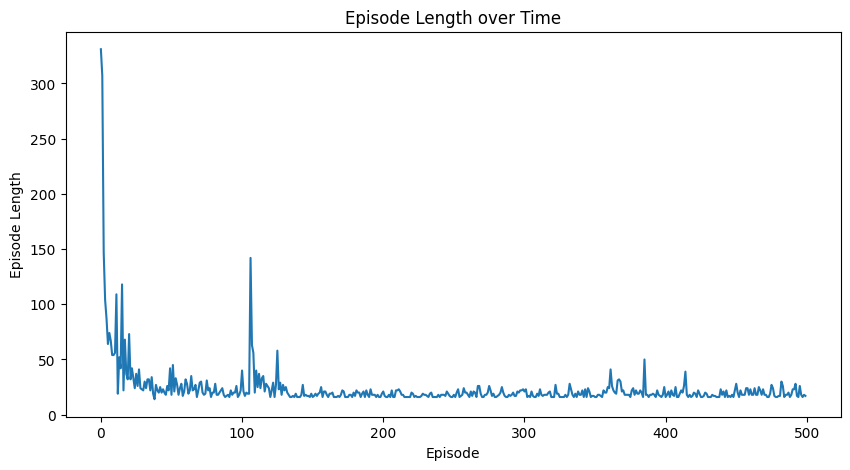

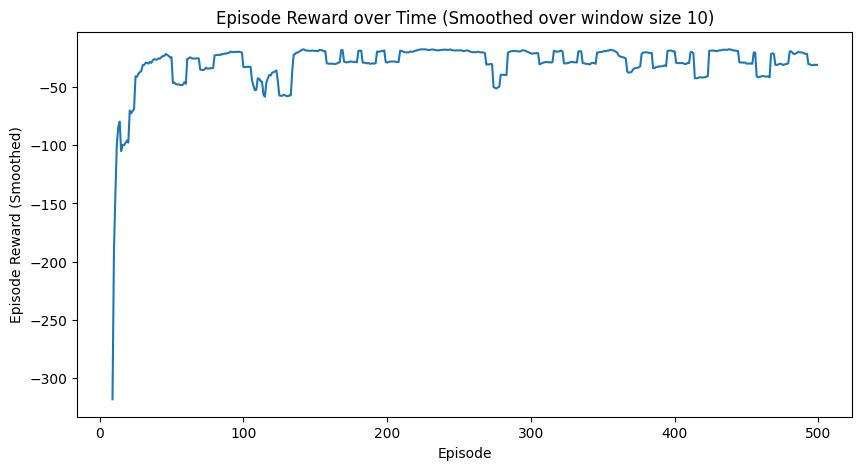

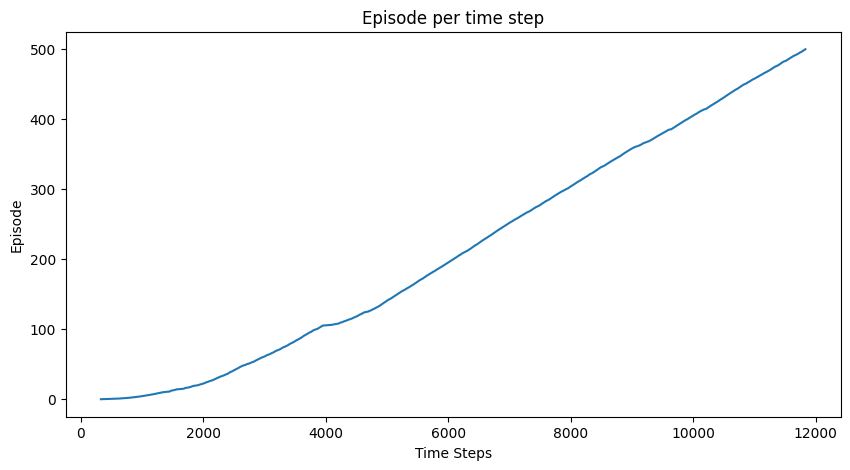

(<Figure size 1000x500 with 1 Axes>,
 <Figure size 1000x500 with 1 Axes>,
 <Figure size 1000x500 with 1 Axes>)

In [43]:
Q, stats_q_learning = SARSA(env, num_episodes=500)
plot_episode_stats(stats_q_learning)